This notebook will calculate the observed fraction of times that it is providing power at a given time of day.

# Method

It will do this by creating a one-minute resolution datetime index for the entire time period.
Each datetime index will have a boolean entry for whether the time falls into one of the message gaps.
A 1 will be assigned for not being in a power down gap and a zero if it is in a power down gap.

These are then summed over an hour to get a crude first look at when power is delivered.

# Result

The overall shape of the plots is what I expect.
It is reasonably constant over the entire day for the grids.
It has much more power delivery during the evening than the day for the microgrids.

I did expect no power delivered during the day, so I'd like to understand if indeed power is being delivered and consumed during the day or if there are power gap data missing that would imply service when there was none.

In [1]:
%load_ext autoreload
%autoreload 2
% matplotlib inline

import pandas as pd
import numpy as np
import WP19_analysis as wpa


# this function has been added to WP19
def wpa_create_uptime_boolean(energy_data, messages):
    index = pd.DatetimeIndex(start=wpa.get_start_time(energy_data),
                             end=wpa.get_end_time(energy_data),
                             freq='1T').values
    power_down = messages[messages['message']=='Power Down'].index.values
    power_up = messages[messages['message']=='Power Up'].index.values

    on = []
    for i in index:
        # if the insertion point of the index is one greater for the power_down time, you are in a gap
        if np.searchsorted(power_down, i) == np.searchsorted(power_up, i) + 1:
            on.append(0)
        else:
            on.append(1)
    
    return pd.DataFrame(index=index, data=on)

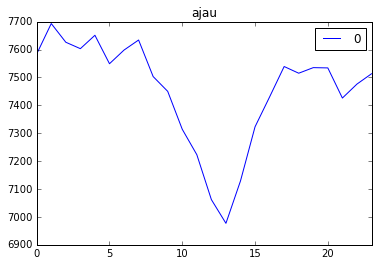

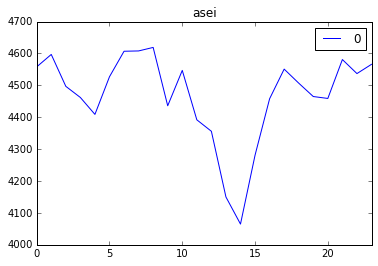

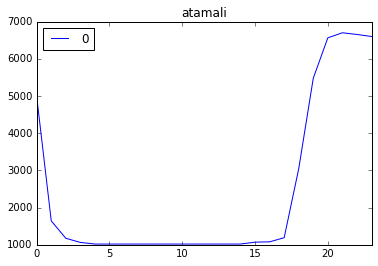

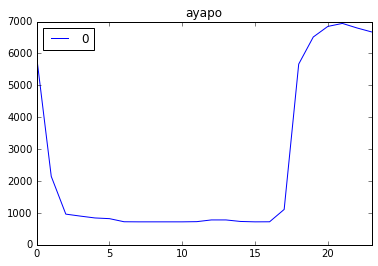

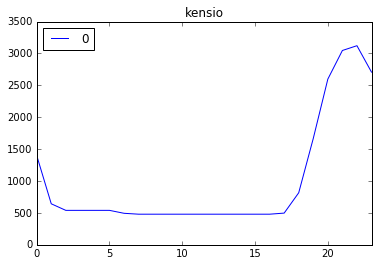

In [2]:
for rfd in wpa.raw_file_data:
    energy_data = wpa.load_timeseries_file(rfd['village_name'] + '-clean.csv')
    messages = wpa.load_message_file(rfd['village_name'] + '-messages.csv')
    on_off = wpa_create_uptime_boolean(energy_data, messages)
    ax = on_off.groupby(on_off.index.hour).sum().plot()
    ax.set_title(rfd['village_name'])


For the microgrids, I don't actually believe the grid is on this much during the day.
There just isn't a reported gap during these times, which seems odd.
The next step is to perform a similar analysis using the time stamp data and see how it matches.